# Análise Espaço-Temporal - Imóveis de São Paulo

## Propósito

Este notebook realiza análises espaço-temporais dos valores imobiliários da cidade de São Paulo utilizando dados de ITBI (Imposto sobre Transmissão de Bens Imóveis) para o período de 2019 a 2024. O objetivo principal é calcular **taxas de valorização** dos imóveis por setor fiscal, identificando padrões de evolução temporal e espacial dos valores por metro quadrado.

## Entradas (Inputs)

### Dados de ITBI
- **Arquivo CSV**: `data/ITBI_2019_2024.csv`
- **Conteúdo**: Dataset consolidado de transações imobiliárias contendo:
  - Número do Cadastro (SQL)
  - Natureza de Transação
  - Valor de Transação (declarado pelo contribuinte)
  - Data de Transação
  - Valor Venal de Referência
  - Proporção Transmitida (%)
  - Área do Terreno (m²)
  - Área Construída (m²)
  - Setor, Quadra e Lote
  - Bairro

## Saídas (Outputs)

### Arquivo CSV - Informações por Setor
- **Nome**: `data/informacao_setor.csv`
- **Conteúdo**: Dataset processado contendo:
  - Taxa de valorização por setor (R$/m² por ano)
  - Valores médios por m² por ano (2019-2024)
  - Classificação de faixa de valorização (comparada com média geral)
  - Informações de bairro associadas

## Processamento Realizado

1. **Carregamento e Limpeza**: Carrega dados de ITBI e aplica filtros de qualidade
2. **Preparação de Dados**: Calcula valores por m² e remove outliers por setor
3. **Análise Temporal Geral**: Calcula estatísticas descritivas e taxa de valorização geral
4. **Análise por Setor**: Calcula taxa de valorização individual por setor usando regressão linear
5. **Classificação**: Classifica setores em faixas de valorização comparadas com média geral
6. **Exportação**: Salva resultados processados em formato CSV


In [ ]:
# Importação de bibliotecas necessárias
import pandas as pd
import numpy as np

In [ ]:
# Configuração para exibir todas as colunas do DataFrame
pd.set_option('display.max_columns', None)

# Carregamento da base de dados ITBI

In [ ]:
# Carrega o arquivo CSV com dados de ITBI (Imposto sobre Transmissão de Bens Imóveis)
# para o período de 2019 a 2024
#itbi = pd.read_csv('drive/MyDrive/ITBI_2019_2024_v3.csv')
itbi = pd.read_csv('data/ITBI_2019_2024.csv')

C:\Users\cazev\AppData\Local\Temp\ipykernel_21860\2366290478.py:2: DtypeWarning: Columns (0,16,17,18) have mixed types. Specify dtype option on import or set low_memory=False.
  itbi = pd.read_csv('data/ITBI_2019_2024.csv')


# Preparação e limpeza da base de dados ITBI

In [ ]:
# Cria cópia do dataframe para tratamento
itbi_tratado = itbi.copy()

# Filtra apenas transações com 100% de proporção transmitida (transações completas)
itbi_tratado = itbi_tratado.loc[itbi['Proporção Transmitida (%)'] == 100]

# Filtra transações com valor mínimo de R$ 1.000 para remover valores inconsistentes
itbi_tratado = itbi_tratado.loc[itbi['Valor de Transação (declarado pelo contribuinte)'] > 1000]

# Remove duplicatas baseadas no número do cadastro SQL e data de transação
itbi_tratado = itbi_tratado.drop_duplicates(subset = ['N° do Cadastro (SQL)', 'Data de Transação'])

# Cria coluna com valor do imóvel (renomeada para facilitar análises)
itbi_tratado['valor_imovel'] = itbi_tratado['Valor de Transação (declarado pelo contribuinte)']

In [19]:
itbi_tratado

,N° do Cadastro (SQL),Natureza de Transação,Valor de Transação (declarado pelo contribuinte),Data de Transação,Valor Venal de Referência,Proporção Transmitida (%),Valor Venal de Referência (proporcional),Base de Cálculo adotada,Tipo de Financiamento,Valor Financiado,Situação do SQL,Área do Terreno (m2),Área Construída (m2),Ano da Transacao,Mes da Transacao,Ano/Mes da Transacao,setor,quadra,lote,bairro,valor_imovel
0,12310100659,1.Compra e venda,900000.00,02/01/2019,773836.0,100.0,773836.0,900000.0,1.Sistema Financeiro de Habitação,400000.00,Ativo Predial,49139,246,2019,1,2019/01,123,101,65,NaN,900000.00
1,5528502403,1.Compra e venda,420000.00,02/01/2019,303832.0,100.0,303832.0,420000.0,1.Sistema Financeiro de Habitação,340721.07,Ativo Predial,5152,109,2019,1,2019/01,55,285,240,NaN,420000.00
2,29903601032,1.Compra e venda,650000.00,03/01/2019,459364.0,100.0,459364.0,650000.0,NaN,0.00,Ativo Predial,1886,98,2019,1,2019/01,299,36,103,NaN,650000.00
3,4201104559,1.Compra e venda,61765.36,03/01/2019,300840.0,100.0,300840.0,300840.0,NaN,0.00,Ativo Predial,1968,84,2019,1,2019/01,42,11,455,NaN,61765.36
4,2206602970,1.Compra e venda,965000.00,03/01/2019,575501.0,100.0,575501.0,965000.0,NaN,0.00,Ativo Predial,1548,172,2019,1,2019/01,22,66,297,NaN,965000.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
908172,14420600100,1.Compra e venda,1550000.00,23/12/2024,1520751.0,100.0,1520751.0,1550000.0,NaN,0.00,Ativo Territorial,937,0,2024,12,2024/12,144,206,10,NaN,1550000.00
908222,23712202448,1.Compra e venda,107500.00,23/12/2024,120996.0,100.0,120996.0,120996.0,1.Sistema Financeiro de Habitação,86000.00,Ativo Predial,9577,53,2024,12,2024/12,237,122,244,JD BARRO BRANCO I,107500.00
908232,10127000010,1.Compra e venda,1200000.00,26/12/2024,0.0,100.0,0.0,1200000.0,NaN,0.00,Ativo Territorial,768,0,2024,12,2024/12,101,270,1,NaN,1200000.00
908342,8236000362,1.Compra e venda,900000.00,26/12/2024,1274811.0,100.0,1274811.0,1274811.0,"99.SFI, Carteira Hipotecária, etc",630000.00,Ativo Territorial,812,0,2024,12,2024/12,82,360,36,NaN,900000.00


In [ ]:
# Cria coluna de área: utiliza área construída se disponível, caso contrário usa área do terreno
itbi_tratado['area'] = itbi_tratado.apply(lambda row: row['Área do Terreno (m2)']
                                          if row['Área Construída (m2)'] == 0
                                          else row['Área Construída (m2)'], axis=1)

# Calcula o valor por metro quadrado (R$/m²)
itbi_tratado['valor_m2'] = itbi_tratado['valor_imovel'] / itbi_tratado['area']

In [ ]:
# Remoção de outliers utilizando método IQR (Interquartile Range) por setor
# Calcula quartis Q1 e Q3 agrupados por setor
Q1 = itbi_tratado.groupby('setor')['valor_m2'].quantile(0.25)
Q3 = itbi_tratado.groupby('setor')['valor_m2'].quantile(0.75)

# Calcula o intervalo interquartil (IQR)
IQR = Q3 - Q1

# Define limites inferior e superior para detecção de outliers (1.5 * IQR)
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Função para filtrar outliers baseada nos limites calculados por setor
def filter_outliers(row):
    sector = row['setor']
    value = row['valor_m2']
    if sector in lower_bound and sector in upper_bound:
        return value >= lower_bound[sector] and value <= upper_bound[sector]
    else:
        return True

# Aplica filtro de outliers
itbi_tratado_filtered = itbi_tratado[itbi_tratado.apply(filter_outliers, axis=1)]

# Exibe dimensões antes e depois da filtragem de outliers
print("Dimensões antes da filtragem de outliers:", itbi_tratado.shape)
print("Dimensões depois da filtragem de outliers:", itbi_tratado_filtered.shape)

Shape before filtering outliers: (584645, 23)
Shape after filtering outliers: (561889, 23)


# Análise temporal e espacial dos valores imobiliários

## Análise Geral - Evolução Temporal dos Valores

In [22]:
# Agrega estatísticas descritivas do valor por m² por ano (análise geral)
# Calcula média, mediana, desvio padrão e contagem de transações por ano
itbi_values_geral = (
    itbi_tratado_filtered
    .groupby(['Ano da Transacao'], as_index = False)
    .agg(
        mean_value = ('valor_m2', 'mean'),      # Valor médio por m²
        median_value = ('valor_m2', 'median'), # Valor mediano por m²
        std_value = ('valor_m2', 'std'),        # Desvio padrão
        count_value = ('valor_m2', 'count')     # Número de transações
    )
)
itbi_values_geral

,Ano da Transacao,mean_value,median_value,std_value,count_value
0,2019,3579.772278,3333.333333,1929.072631,83647
1,2020,3763.983535,3476.872134,2023.518084,84336
2,2021,3938.803260,3663.865546,2053.435780,116809
3,2022,4043.688203,3750.000000,2133.769548,94045
4,2023,4192.824136,3882.381724,2267.265247,91895
5,2024,4414.693693,4101.123596,2349.001962,91157


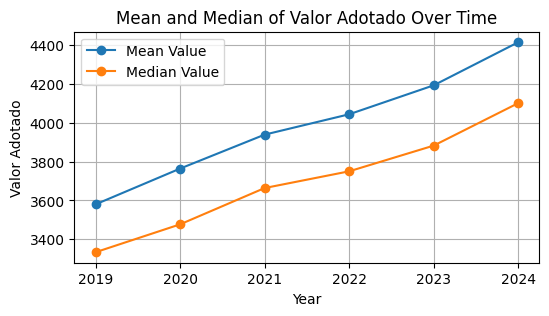

In [23]:
import matplotlib.pyplot as plt

# Visualização da evolução temporal dos valores médio e mediano por m² ao longo dos anos
plt.figure(figsize=(6, 3))

plt.plot(itbi_values_geral['Ano da Transacao'], itbi_values_geral['mean_value'], marker='o', label='Valor Médio')
plt.plot(itbi_values_geral['Ano da Transacao'], itbi_values_geral['median_value'], marker='o', label='Valor Mediano')

plt.title('Evolução Temporal dos Valores Médio e Mediano por m²')
plt.xlabel('Ano')
plt.ylabel('Valor por m² (R$)')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
from sklearn.linear_model import LinearRegression

# Calcula taxa de valorização geral utilizando regressão linear
# A taxa de valorização é o coeficiente angular da reta de tendência
X = itbi_values_geral[['Ano da Transacao']]
y = itbi_values_geral['mean_value']
model = LinearRegression()
model.fit(X, y)

# Taxa de valorização geral (R$/m² por ano)
valorizacao_geral = float(model.coef_[0])

In [25]:
valorizacao_geral

159.02896641268222

## Análise por Setor - Valorização Espacial e Temporal

In [ ]:
# Agrega estatísticas descritivas do valor por m² por setor, bairro e ano
# Calcula média, mediana, desvio padrão e contagem de transações
itbi_values = (
    itbi_tratado_filtered
    .groupby(['setor','bairro','Ano da Transacao'], as_index = False)
    .agg(
        mean_value = ('valor_m2', 'mean'),      # Valor médio por m²
        median_value = ('valor_m2', 'median'),  # Valor mediano por m²
        std_value = ('valor_m2', 'std'),        # Desvio padrão
        count_value = ('valor_m2', 'count')     # Número de transações
    )
)

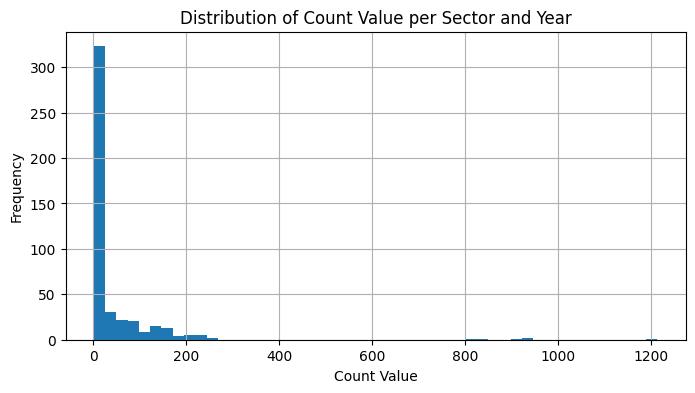

In [27]:
# Visualização da distribuição do número de transações por setor e ano
plt.figure(figsize=(8, 4))
plt.hist(itbi_values['count_value'], bins=50)
plt.title('Distribuição do Número de Transações por Setor e Ano')
plt.xlabel('Número de Transações')
plt.ylabel('Frequência')
plt.grid(True)
plt.show()

In [ ]:
# Filtra apenas setores com pelo menos 100 transações por ano para garantir robustez estatística
itbi_values = itbi_values.loc[itbi_values['count_value'] > 100]

# Conta quantos anos cada setor possui dados
agg_setor = (
    itbi_values
    .groupby('setor', as_index = False)
    .agg(
        num_anos = ('Ano da Transacao', 'count')
    )
)

# Filtra apenas setores com dados em pelo menos 4 anos (necessário para análise de tendência)
itbi_values = (
    itbi_values
    .merge(
        agg_setor.loc[agg_setor.num_anos >= 4],
        how = 'inner',
        on = 'setor'
        )
)
itbi_values

,setor,bairro,Ano da Transacao,mean_value,median_value,std_value,count_value,num_anos
0,21,PERDIZES,2019,4470.093514,4458.974359,1851.169442,843,6
1,21,PERDIZES,2020,4846.541932,4808.608059,2037.157514,820,6
2,21,PERDIZES,2021,4925.927847,5000.000000,1939.383365,1213,6
3,21,PERDIZES,2022,4964.003429,5000.000000,1902.252883,900,6
4,21,PERDIZES,2023,5379.457254,5434.782609,2055.970812,925,6
5,21,PERDIZES,2024,5761.412930,5900.366126,2389.705702,946,6
6,96,ALTO DE PINHEIROS,2019,5944.241288,5667.341430,2780.477082,146,6
7,96,ALTO DE PINHEIROS,2020,5524.030893,5384.615385,2742.543836,143,6
8,96,ALTO DE PINHEIROS,2021,6446.022418,6160.714286,3069.573234,238,6
9,96,ALTO DE PINHEIROS,2022,6813.762925,6392.640693,3344.513083,164,6


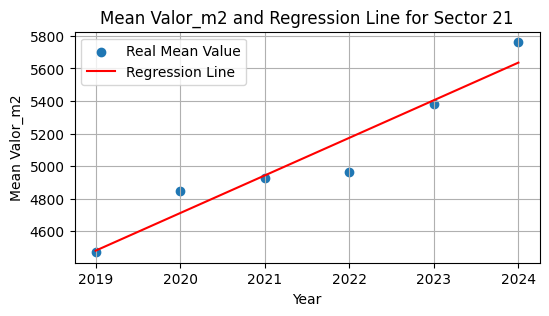

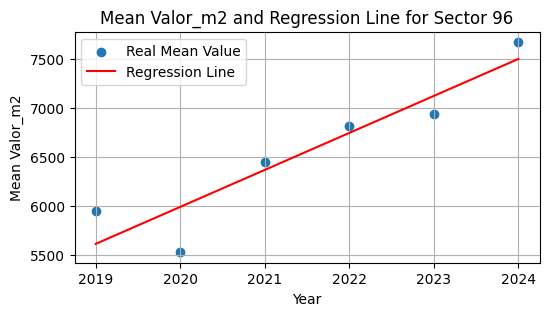

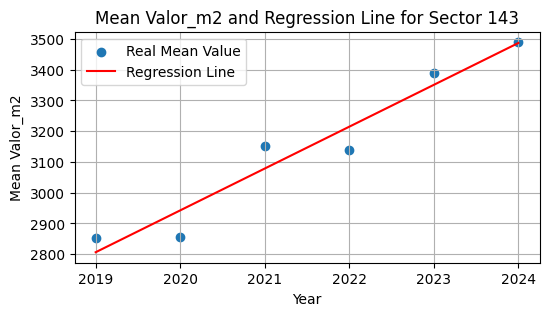

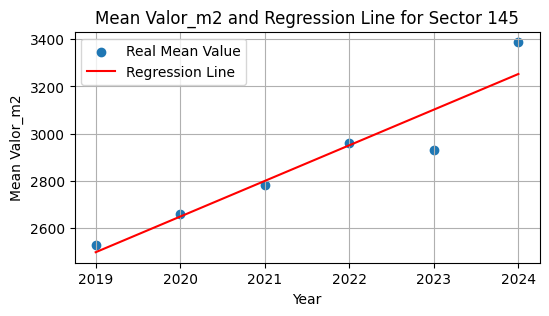

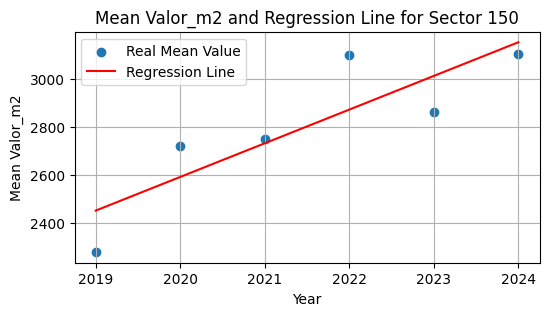

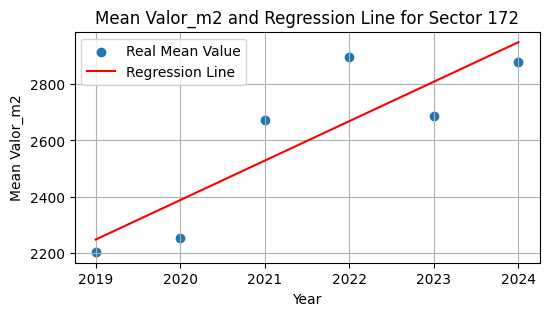

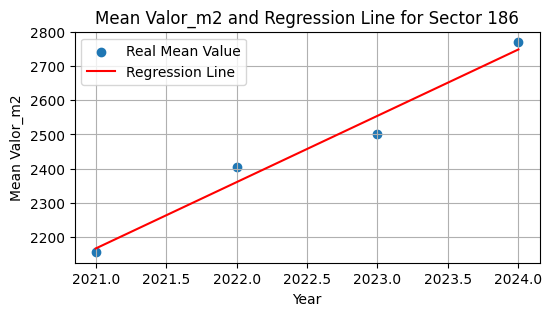

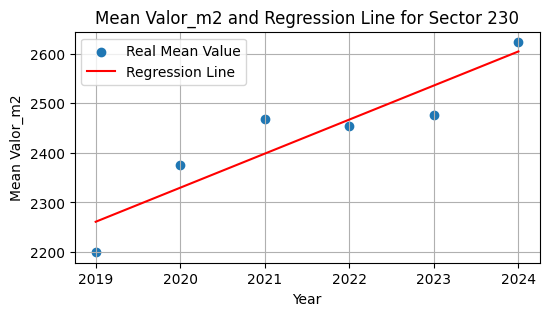

In [ ]:
from sklearn.linear_model import LinearRegression
import pandas as pd
import matplotlib.pyplot as plt

# Calcula taxa de valorização por setor utilizando regressão linear
# Para cada setor, ajusta uma reta de tendência e extrai o coeficiente angular
growth_rates = {}
for setor in itbi_values['setor'].unique():
    base = itbi_values.loc[itbi_values.setor == setor].copy()

    # Verifica se há dados suficientes para regressão (pelo menos 2 pontos)
    if len(base) > 1:
        X = base[['Ano da Transacao']]
        y = base['mean_value']
        model = LinearRegression()
        model.fit(X, y)

        # Extrai taxa de valorização (coeficiente angular da reta)
        growth_rates[setor] = model.coef_[0]

        # Visualização da regressão para cada setor
        plt.figure(figsize=(6, 3))
        plt.scatter(X, y, label='Valor Médio Real')
        plt.plot(X, model.predict(X), color='red', label='Reta de Regressão')
        plt.title(f'Valor Médio por m² e Reta de Regressão - Setor {setor}')
        plt.xlabel('Ano')
        plt.ylabel('Valor Médio por m² (R$)')
        plt.legend()
        plt.grid(True)
        plt.show()

    else:
        growth_rates[setor] = None  # Setor sem dados suficientes

# Armazena resultados em DataFrame
growth_rates_df = pd.DataFrame.from_dict(growth_rates, orient='index', columns=['taxa_valorizacao'])
growth_rates_df.index.name = 'setor'
growth_rates_df.reset_index(inplace=True)



In [ ]:
# Cria tabela pivot com valores médios por m² por setor/bairro e ano
# Facilita visualização da evolução temporal por localização
itbi_values_pivot = (
    itbi_values
    .pivot_table(
        index = ['setor','bairro'],
        columns = 'Ano da Transacao',
        values = 'mean_value'
    )
    .reset_index()
)

In [ ]:
# Remove setores sem taxa de valorização calculada
growth_rates_df = growth_rates_df.dropna()

# Combina taxa de valorização com valores históricos por ano
base_final = (
    growth_rates_df
    .merge(
        itbi_values_pivot,
        how = 'left',
        on = 'setor'
    )
)

In [ ]:
# Função para classificar setores em faixas de valorização
# Compara taxa de valorização do setor com a taxa geral da cidade
def get_faixa_valorizacao(taxa_valorizacao):
    if taxa_valorizacao <= 0:
      return 'Desvalorização'
    elif taxa_valorizacao < valorizacao_geral:
      return 'Valorização abaixo do geral'
    else:
      return 'Valorização acima do geral'

In [ ]:
# Aplica classificação de faixa de valorização para cada setor
base_final['faixa_valorizacao'] = base_final['taxa_valorizacao'].apply(get_faixa_valorizacao)

In [ ]:
# Ordena setores por taxa de valorização (maior para menor)
base_final.sort_values(by='taxa_valorizacao', ascending=False)

,setor,taxa_valorizacao,bairro,2019,2020,2021,2022,2023,2024,faixa_valorizacao
1,96,379.024423,ALTO DE PINHEIROS,5944.241288,5524.030893,6446.022418,6813.762925,6938.069358,7675.441069,Valorização acima do geral
0,21,231.240532,PERDIZES,4470.093514,4846.541932,4925.927847,4964.003429,5379.457254,5761.412930,Valorização acima do geral
6,186,194.228977,CJ HAB RAPOSO TAVARES,NaN,NaN,2155.092483,2403.223362,2501.173447,2769.872376,Valorização acima do geral
3,145,151.312884,ITAQUERA,2528.205165,2658.951582,2781.821774,2959.192023,2932.424615,3387.837484,Valorização abaixo do geral
4,150,140.971631,ITAQUERA,2275.626384,2719.912212,2747.486372,3102.172949,2861.283021,3106.668003,Valorização abaixo do geral
5,172,140.770458,AMERICANOPOLIS,2201.340350,2252.277535,2671.865833,2897.501742,2686.803054,2880.891060,Valorização abaixo do geral
2,143,136.192927,CONJ PE M DA NOBREGA,2853.159872,2857.039612,3151.243395,3140.154924,3388.909944,3489.605853,Valorização abaixo do geral
7,230,68.690710,CJ HAB JOSE BONIFACIO,2199.707319,2375.579706,2468.796719,2453.689593,2476.180832,2623.203041,Valorização abaixo do geral


In [ ]:
# Exporta base final com informações de valorização por setor para arquivo CSV
base_final.to_csv('data/informacao_setor.csv', index = False)